### 멀티클래스에 interpret를 추가하고 VQC(output_shape=num_classes) 
1. output_shape = num_classes
2. interpret = index% num_classes
3. feature=4

In [1]:
import datetime
import time
import qiskit
import tensorflow 
import platform

datetime.datetime.now()

print('qiskit version:', qiskit.__version__)
print('tf     version:', tensorflow.__version__)
print('Python Version:',platform.python_version())
print('OS            :', platform.system())
print('코딩시간       :', time.strftime("%a %b %d %H:%M:%S %Y %Z"))
print('Copyright     : Hongsuk (hongsuk.yi@gmail.com)')

qiskit version: 1.4.2
tf     version: 2.18.0
Python Version: 3.10.0
OS            : Windows
코딩시간       : Thu Mar 20 19:05:57 2025 대한민국 표준시
Copyright     : Hongsuk (hongsuk.yi@gmail.com)


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
#sklearn
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from mlxtend.plotting import plot_decision_regions

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam 

## 포팅

In [5]:
# from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import SPSA, L_BFGS_B, COBYLA
from qiskit_machine_learning.algorithms import VQC, QSVC, NeuralNetworkClassifier 

from qiskit.primitives import Sampler

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2, TwoLocal
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.utils import algorithm_globals

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df_orig = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16_L3_5m_Days20.csv")
#df = pd.read_csv("./vds16_L3_120m_Days20.csv")

## Feature selection

In [8]:
df_orig.head()

,Unnamed: 0,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate,Hour,tfi,rho,label
0,288,2017-04-03 00:00:00,30,21,9,0,58.6,1.09,0,0.123,0.044,Fast
1,289,2017-04-03 00:05:00,28,17,11,0,57.5,1.29,0,0.112,0.041,Fast
2,290,2017-04-03 00:10:00,42,33,8,1,53.1,1.53,0,0.156,0.073,Fast
3,291,2017-04-03 00:15:00,32,22,9,1,56.2,1.25,0,0.126,0.050,Fast
4,292,2017-04-03 00:20:00,22,15,7,0,52.8,1.02,0,0.081,0.034,Fast


In [9]:
# 각 라벨별 샘풀링 개수 : 200개
sample_per_label = 500

In [10]:
#각 라벨별로 200개씩 샘플링
df = df_orig.groupby('label').apply(lambda x: x.sample(n=sample_per_label, random_state=42)).reset_index(drop=True)

In [11]:
# 결과 확인
label_counts = df['label'].value_counts()
print(label_counts)

label
Fast    500
Jam     500
Slow    500
Name: count, dtype: int64


In [12]:
df.head()

,Unnamed: 0,Date,ToVol,SmVol,MeVol,LaVol,Speed,OccRate,Hour,tfi,rho,label
0,5469,2017-04-20 23:45:00,57,42,15,0,52.1,2.29,23,0.207,0.105,Fast
1,2645,2017-04-11 04:25:00,29,22,6,1,49.3,1.64,4,0.100,0.052,Fast
2,4351,2017-04-17 02:35:00,18,14,4,0,59.3,0.67,2,0.075,0.022,Fast
3,5466,2017-04-20 23:30:00,59,45,14,0,52.6,2.86,23,0.217,0.108,Fast
4,2614,2017-04-11 01:50:00,16,6,10,0,52.0,0.60,1,0.058,0.023,Fast


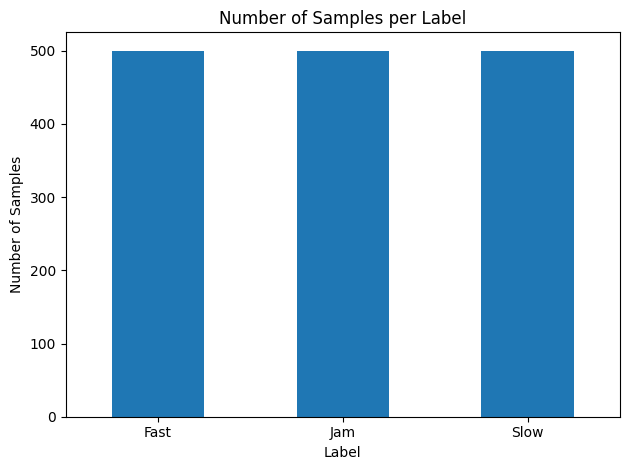

In [13]:
# pandas plot을 사용하여 bar chart 그리기
label_counts.plot(kind='bar', title='Number of Samples per Label')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0) # x축 라벨 회전 (필요에 따라 조절)
plt.tight_layout() # 레이아웃 조정
plt.show()

In [14]:
df.columns

Index(['Unnamed: 0', 'Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed',
       'OccRate', 'Hour', 'tfi', 'rho', 'label'],
      dtype='object')

<Axes: xlabel='ToVol', ylabel='tfi'>

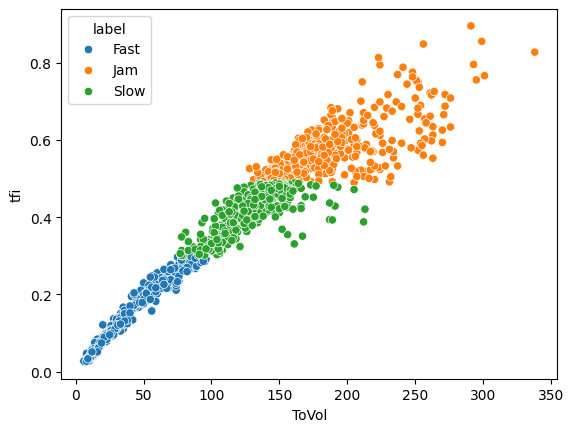

In [15]:
sns.scatterplot(df, x = 'ToVol', y = 'tfi', hue='label') 

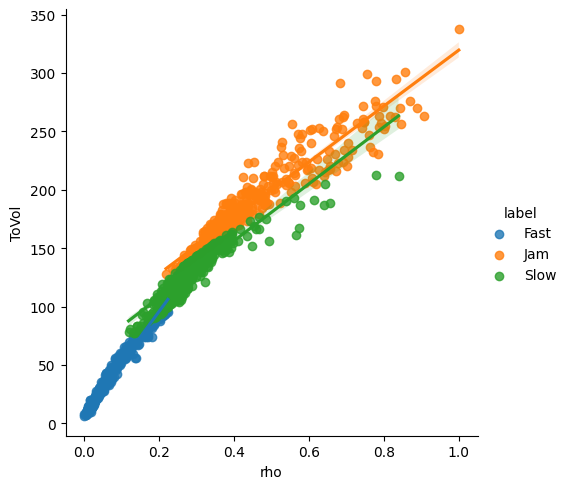

In [16]:
sns.lmplot( x = 'rho', y = 'ToVol', hue='label', data=df)

# Classical classifiers 

In [17]:
df.columns

Index(['Unnamed: 0', 'Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed',
       'OccRate', 'Hour', 'tfi', 'rho', 'label'],
      dtype='object')

In [18]:
# classical SVM
X = df[['rho', 'ToVol', 'Speed','Hour' ]]
y = df['label']

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)
print(X_scaled[:5,:])

(1500, 4)
[[-0.8457886  -0.87153739  0.41813605  1.69856831]
 [-1.14219155 -1.29228925  0.01722944 -1.06988627]
 [-1.3099668  -1.45758463  1.44903876 -1.36130254]
 [-0.82901108 -0.84148369  0.48972652  1.69856831]
 [-1.30437429 -1.48763833  0.40381796 -1.50701068]]


In [20]:
y_enc = LabelEncoder().fit_transform(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.20)

In [22]:
X_test2F=X_test[:, :2]
X_test2F.shape

(300, 2)

## SVM

In [23]:
acc_sv=0.0
acc_ann=0.0
acc_dnn=0.0
acc_qsvc=0.0
acc_vqc=0.0

In [24]:
# Create svm Classifier
model  = SVC()
svm = model.fit(X_train, y_train)

In [25]:
y_pred = model.predict(X_test)

acc_svc =  metrics.accuracy_score(y_test, y_pred)
print("\n- Accuracy of Classical SVC:",acc_svc)
print('\n- Confustion Matrix:\n', metrics.confusion_matrix(y_test,y_pred))
print('\n- Classification Report:\n',metrics.classification_report(y_test, y_pred))


- Accuracy of Classical SVC: 0.97

- Confustion Matrix:
 [[ 88   0   2]
 [  0 101   4]
 [  2   1 102]]

- Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.99      0.96      0.98       105
           2       0.94      0.97      0.96       105

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [26]:
# confusion matrix of SVM
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 

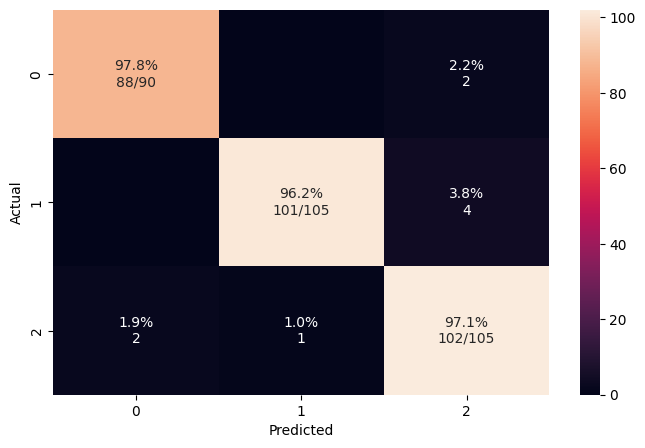

In [27]:
 cm_analysis(y_test, y_pred, labels=None, ymap=None, figsize=(8,5)) 

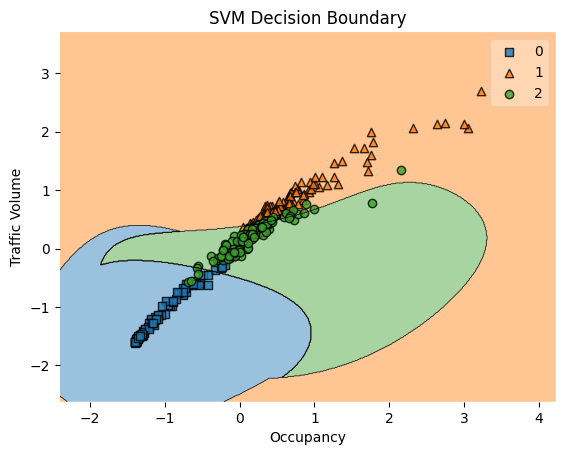

In [28]:
model.fit(X_test2F, y_test)

plot_decision_regions(X_test2F, y_test, clf=model)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('SVM Decision Boundary')
plt.show()

## ANN

In [29]:
# classical QNN 
model_ann = MLPClassifier(max_iter=1000,  random_state=5)
model = model_ann
model = model.fit(X_train, y_train)

In [30]:
y_pred = model.predict(X_test)
acc_ann = metrics.accuracy_score(y_test, y_pred)
print("\n- Accuracy of Classical SVC:",acc_ann)
print('\n- Confustion Matrix:\n', metrics.confusion_matrix(y_test,y_pred))
print('\n- Classification Report:\n',metrics.classification_report(y_test, y_pred))


- Accuracy of Classical SVC: 0.99

- Confustion Matrix:
 [[ 89   0   1]
 [  0 104   1]
 [  0   1 104]]

- Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.99      0.99      0.99       105
           2       0.98      0.99      0.99       105

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



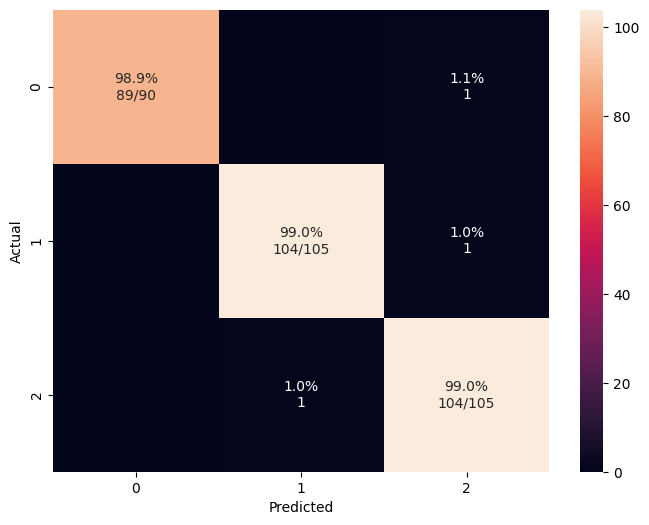

In [31]:
cm_analysis(y_test, y_pred,labels=None, ymap=None, figsize=(8,6)) 

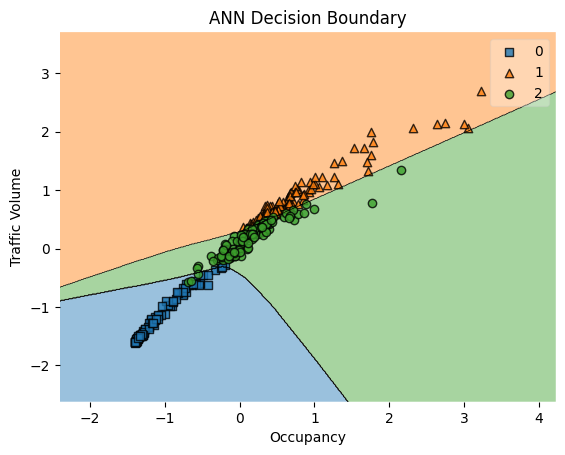

In [32]:
model.fit(X_test2F, y_test)

plot_decision_regions(X_test2F, y_test, clf=model)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('ANN Decision Boundary')
plt.show()

## Deep Neural Network MLP

In [33]:
num_classes = y.nunique()
print(f"클래스 개수: {num_classes}")

num_features = X_train.shape[1]
print('특성 개수  :',num_features)

클래스 개수: 3
특성 개수  : 4


In [34]:
model_dnn = Sequential([
    Dense(64, input_dim=num_features, activation = 'relu'),
    Dense(32, activation= 'relu'),
    Dense(num_classes, activation= 'softmax')])  
model_dnn2 = Sequential([
    Dense(64, input_dim= 2, activation = 'relu'),
    Dense(32, activation= 'relu'),
    Dense(num_classes, activation= 'softmax')])  

In [35]:
model = model_dnn
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = 'adam', metrics = ['accuracy'])

In [36]:
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2,verbose=0)

In [37]:
_, acc_dnn = model.evaluate(X_test,y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9692 - loss: 0.0629 


In [38]:
print("\n- Accuracy of Classical DNN:",acc_dnn)


- Accuracy of Classical DNN: 0.9733333587646484


In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

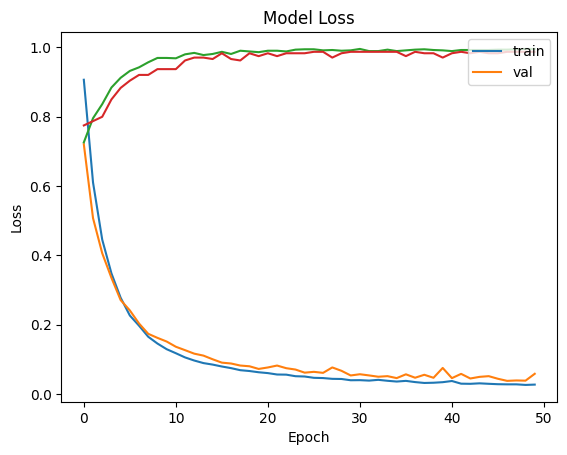

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


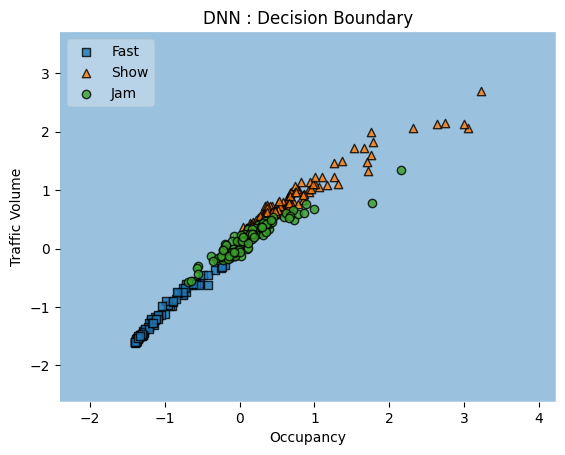

In [41]:
class Onehot2Int(object):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)   

model_one =Onehot2Int(model_dnn2)

ax=plot_decision_regions(X_test2F, y_test, clf=model_one)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('DNN : Decision Boundary')

handles, labels = ax.get_legend_handles_labels()
if num_classes == 3 : 
    ax.legend(handles, [ 'Fast', 'Show', 'Jam'],  framealpha=0.3, scatterpoints=1)
plt.show()


# Quantum Simulator for Quantum Classification

In [42]:
import time
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit.circuit.library import ZZFeatureMap,  RealAmplitudes
# from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

### 1) VQC

feature map
- from classical data to qubit through data encoding, data embedding, data loading
- The most standard fearture is ZZFeatureMap

ansatz

- apply a parameterize quantum circuit.
- objective function characterized the distance between the prediction and known labeled data.
- A parametrized quantum circuit is call a paramenterized trial state, variational form, or ansatz.- 

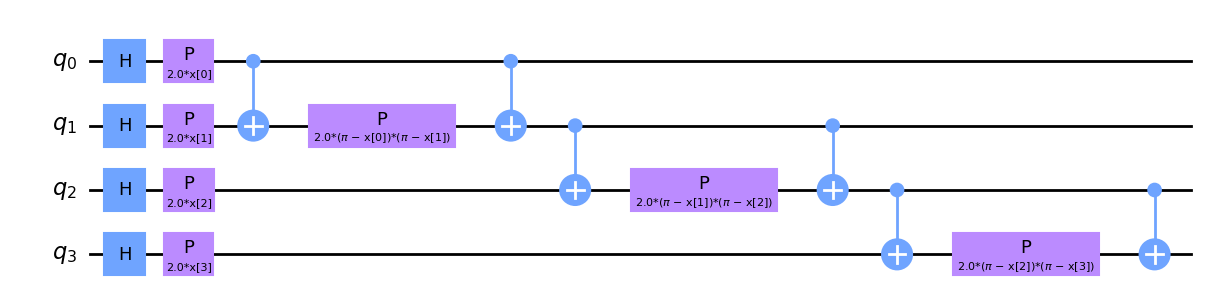

In [43]:
feature_map = ZZFeatureMap(feature_dimension = num_features , reps=1, entanglement="linear")
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

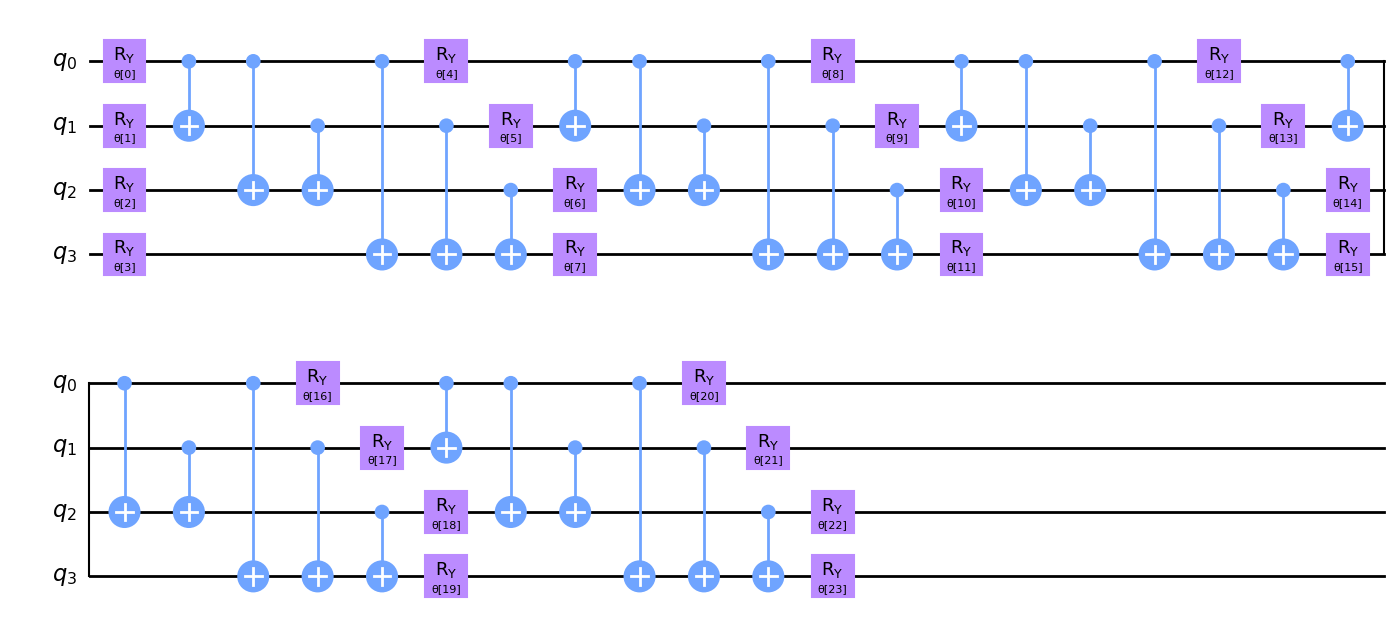

In [44]:
ansatz = RealAmplitudes(num_qubits = num_features , reps=5,entanglement="full")
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

StatevectorSampler를 이용한 Simulator

In [45]:
sampler = Sampler()

In [46]:
def multi_class_interpret(measured_integer):
    """측정된 정수를 num_classes으로 나눈 나머지를 클래스 인덱스로 반환"""
    return measured_integer % num_classes
    
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Onh-hot encoded format의 경우 crossEntropyLoss를 사용한다.

In [47]:
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
optimizer = COBYLA(maxiter=200)

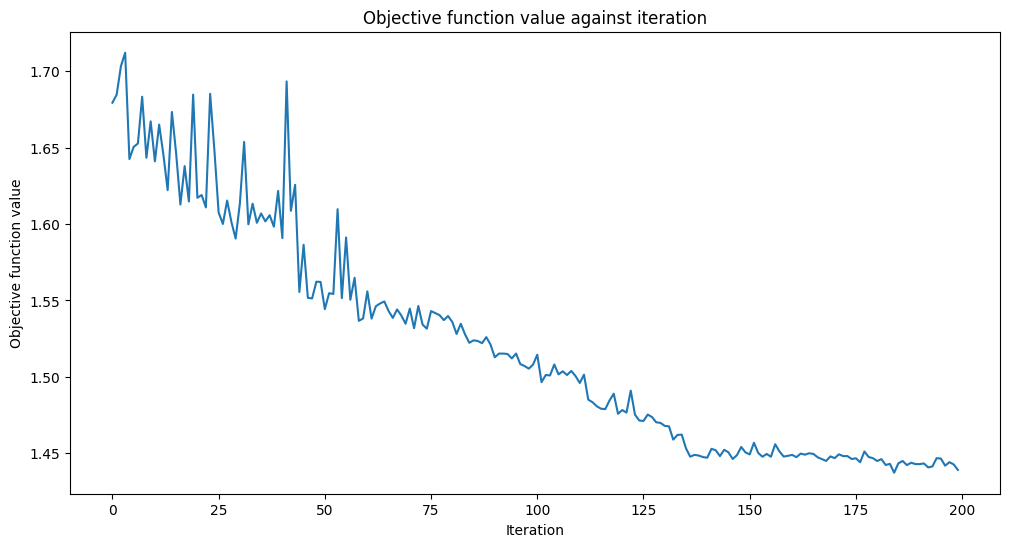

Training time: 4779 seconds


In [48]:
plt.rcParams["figure.figsize"] = (12, 6)

import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    output_shape=num_classes,
    interpret=multi_class_interpret  # interpret 함수 추가
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [49]:
train_score_q4 = vqc.score(X_train, y_train)
acc_vqc = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset    : {acc_vqc:.2f}")

Quantum VQC on the training dataset: 0.51
Quantum VQC on the test dataset    : 0.46


In [50]:
cost_vqc_train = objective_func_vals

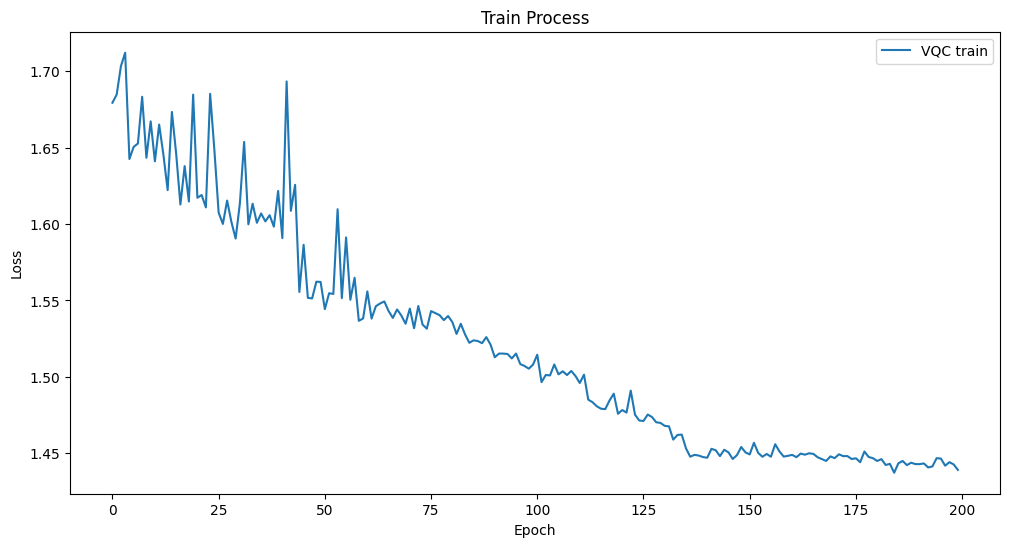

In [51]:
# 훈련 정확도 그래프
plt.plot(cost_vqc_train)
#plt.plot(history.history['val_accuracy'])
plt.title('Train Process')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['VQC train'])
plt.show()

VQC performance

In [52]:
# classification report of VQC

y_pred = vqc.predict(X_test)

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(y_test, y_pred))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.38      0.66      0.48        90
           1       0.47      0.30      0.36       105
           2       0.56      0.42      0.48       105

    accuracy                           0.45       300
   macro avg       0.47      0.46      0.44       300
weighted avg       0.48      0.45      0.44       300

Confusion matrix: 
 [[59 16 15]
 [55 31 19]
 [42 19 44]]


In [53]:
predict = vqc.predict(X_test)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test}")

Predicted labels: [0 0 0 0 2 0 1 0 0 1 2 1 1 1 0 0 1 0 0 0 1 0 2 0 0 0 1 0 0 0 0 2 0 0 0 1 1
 1 0 2 0 2 0 0 1 0 0 2 2 0 1 0 1 2 0 2 0 1 1 0 0 0 0 1 0 0 1 2 0 0 2 0 2 0
 0 2 0 2 0 2 2 0 0 1 0 1 0 2 1 0 0 0 1 0 0 1 2 2 2 0 1 2 0 0 0 2 2 0 2 1 1
 2 0 2 0 0 0 0 1 1 0 1 0 1 1 1 2 2 0 0 0 2 0 0 1 1 0 1 2 2 1 2 0 1 0 2 0 1
 0 0 2 0 2 1 2 0 0 2 0 0 2 0 0 0 0 1 2 0 0 0 0 2 0 0 2 2 2 0 1 0 1 0 0 0 2
 0 0 2 0 2 0 0 1 0 1 2 0 2 2 1 0 0 2 0 0 0 0 2 0 2 1 0 1 0 1 0 2 2 1 2 2 0
 1 0 0 0 2 0 1 1 0 0 2 0 0 1 0 1 1 0 2 1 1 0 0 2 2 2 1 2 0 2 2 0 0 2 0 0 2
 2 2 1 0 1 0 1 2 2 0 2 0 1 2 2 0 2 1 1 1 0 1 0 0 2 1 0 2 2 1 0 0 0 0 1 1 2
 0 1 1 0]
Ground truth:     [0 1 2 1 0 2 2 0 2 1 0 2 1 1 2 0 2 0 1 1 1 1 0 0 0 0 2 1 1 0 2 2 1 0 1 0 2
 0 2 2 2 2 0 0 0 2 0 2 0 1 2 1 2 0 1 2 2 2 2 0 2 1 0 0 1 0 0 2 1 0 1 0 2 1
 0 0 0 0 2 2 2 0 1 0 0 1 1 2 2 2 2 2 1 1 0 1 0 2 2 2 0 1 0 1 1 2 1 1 2 1 0
 2 0 0 2 1 1 2 0 1 0 1 0 1 2 1 2 2 1 2 1 1 2 1 2 0 0 2 2 2 2 0 0 2 2 1 1 1
 1 1 0 1 2 1 2 1 0 2 2 2 2 1 1 0 0 2 1 1 1 2 0 1 2 1 1

<Axes: xlabel='models'>

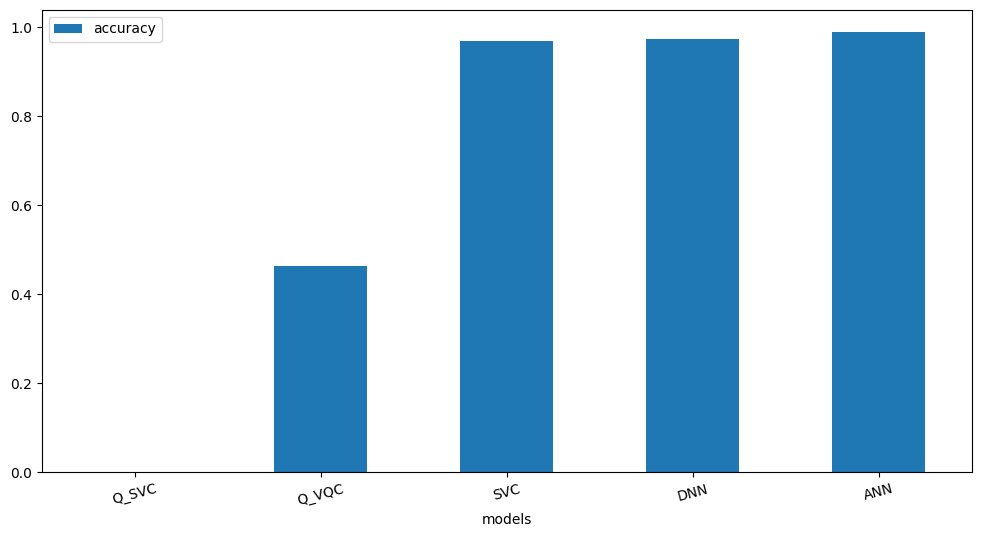

In [54]:
df = pd.DataFrame({
    'models': ['SVC', 'ANN','DNN','Q_SVC', 'Q_VQC'],
    'accuracy':[acc_svc, acc_ann, acc_dnn, acc_qsvc, acc_vqc]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)

### 2) Quantum SVC

In [55]:
fm_qsvc = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2, entanglement="linear")
fm_qsvc.decompose().draw(output="mpl", style="clifford", fold=20)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
qsvc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm_qsvc)
qsvc = QSVC(quantum_kernel=qsvc_kernel)

In [ ]:
start = time.time()
qsvc.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [ ]:
acc_qsvc = qsvc.score(X_test, y_test)
print(f"QSVC classification test score: {acc_qsvc}")

In [ ]:
df = pd.DataFrame({
    'models': ['SVC', 'ANN','DNN','Q_SVC', 'Q_VQC'],
    'accuracy':[acc_svc, acc_ann, acc_dnn, acc_qsvc, acc_vqc]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)

In [ ]:
# classification report of QSVC
y_pred = qsvc.predict(X_test) 
metrics.classification_report(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
print(f"acc_svc 타입: {type(acc_svc)}")
print(f"acc_ann 타입: {type(acc_ann)}")
print(f"acc_dnn 타입: {type(acc_dnn)}")
print(f"acc_qsvc 타입: {type(acc_qsvc)}")
print(f"acc_vqc 타입: {type(acc_vqc)}")